In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import scipy as sp
import torch as t
import torchvision as tv
from sklearn.decomposition import PCA
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
from torchvision.utils import save_image
import imageio
import os
import math
seed = 7
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
from collections import defaultdict
from functools import lru_cache
import numpy as np
import matplotlib.pylab as plt

def predict(model, dataset):
    return model.predict(dataset).argmax(axis=-1)

def get_images_classes(dataset):

    images = np.concatenate([x for x, y in dataset], axis=0)
    classes = np.concatenate([y for x, y in dataset], axis=0)

    return images, classes

def display_image(image):
    """
    displays an image
    """
    plt.imshow(image.squeeze())

def get_eucliean_dist(image1, image2):
    """
    gets the euclidean distance between two images
    """
    im1 = image1.flatten()
    im2 = image2.flatten()

    dist = np.linalg.norm(im1 - im2)

    return dist

def get_distances(average_hashmap, image):
    """
    takes in the average image hashmap and an image, and returns
    a hashmap with the same classes but with the euclidean distance from
    those mean images
    """
    hashmap = {}

    for key in average_hashmap:
        avg_image = average_hashmap[key]
        dist = get_eucliean_dist(avg_image, image)
        hashmap[key] = dist

    return hashmap

def get_rank(hashmap, key):
    """
    gets the relative rank of that key in the hashmap.
    """

    # get the keys sorted by value
    sorted_ = sorted(hashmap, key=hashmap.get)

    # create map where key is the key, value is the rank
    map_ = {key: rank for rank, key in enumerate(sorted_, start=1)}

    return map_[key]

class Confusion:
    def __init__(self, model, dataset):
        """
        initializer
        """
        self.model = model
        self.images = np.concatenate([x for x, y in dataset], axis=0)
        self.classes = np.concatenate([y for x, y in dataset], axis=0)
        self.predictions = model.predict(dataset).argmax(axis=-1)
        self.map = self.create_hashmap()
    
    def confusion_matrix(self):
        return ConfusionMatrixDisplay(
            confusion_matrix(self.classes, self.predictions)
        )
        
    def create_hashmap(self):
        """
        creates hashmap data structure:
        map[true_class][predicted_class] = list of images
        """
        hashmap = defaultdict(lambda: defaultdict(list))
        for image, class_, prediction in zip(self.images, self.classes, self.predictions):
            hashmap[class_][prediction].append(np.array(image))
        return hashmap
    
    def print_confusion(self):
        """
        print basic confusion matrix numbers
        """
        classes = list(set(self.classes))
        for true_class in classes:
            for predicted_class in classes:
                print(len(self.map[true_class][predicted_class]),end=" ")
            print()
    
    def average_image(self, images):
        """
        returns the average image from a list of images
        """
        images_numpy = np.array(images)
        mean_image = images_numpy.mean(axis=0)
        return mean_image
        
    def get_classified(self, true_class, predicted_class):
        """
        returns the images of class true_class that are predicted as predicted_class.
        If true_class = None, then will get all images predicted as predicted_class.
        If predicted_class = None, then will get all images that are really true_class.
        """
        if true_class == None:
            classes = list(set(self.classes))
            images = []
        
            for class_ in classes:
                images.extend(self.map[class_][predicted_class])

        elif predicted_class == None:
            classes = list(set(self.classes))
            images = []
        
            for class_ in classes:
                images.extend(self.map[true_class][class_])
        
        else:
            images = self.map[true_class][predicted_class]


#         if images == []:
#             return -1
# #             raise Exception(f'There are no images of class {true_class} that were classified as {predicted_class}')
        return images

    def average_image_hashmap(self):
        """
        returns hashmap where each class is a key, and the value is the average image
        for that class
        """
        hashmap = {}
        classes = list(set(self.classes))
        for class_ in classes:
            average_image = self.get_mean_image(class_, None)
            hashmap[class_] = average_image

        return hashmap

    # @lru_cache(maxsize=None)
    def get_mean_image(self, true_class, predicted_class):
        """
        returns the mean image for images classified of class true_class that are predicted as predicted_class
        """
        images = self.get_classified(true_class, predicted_class)
        if images == []:
            return []
        return self.average_image(images)
        
    def get_difference(self, image_1, image_2):
        """
        returns the difference between two images
        """
        return np.subtract(image_1, image_2)
    
    def negate_negatives(self, image):
        """
        returns image after negating negative values
        """
        return np.where(image<0, 0, image)
    
    def get_positive_difference(self, image_1, image_2):
        """
        returns the difference between two images with negatives set to zero
        """
        image_difference = self.get_difference(image_1, image_2)
        image_positive = self.negate_negatives(image_difference)
        return image_positive
        
    def get_difference_classes(self, true_class_1, predicted_class_1, true_class_2, predicted_class_2):
        """
        returns the difference of the mean images of true_class_1 predicted as predicted_class_1 minus
        images of true_class_2 predicted as predicted_class_2
        """
        image_1 = self.get_mean_image(true_class_1, predicted_class_1)
        image_2 = self.get_mean_image(true_class_2, predicted_class_2)
        
        diff = self.get_difference(image_1, image_2)
        return diff
        
        
    def get_positive_difference_classes(self, true_class_1, predicted_class_1, true_class_2, predicted_class_2):
        """
        returns the positive difference of images of true_class_1 predicted as predicted_class_1 minus
        images of true_class_1 predicted as predicted_class_1
        """
        image_1 = self.get_mean_image(true_class_1, predicted_class_1)
        image_2 = self.get_mean_image(true_class_2, predicted_class_2)
        
        diff = self.get_positive_difference(image_1, image_2)
        return diff
    
    def get_false_positives(self, predicted_class):
        """
        returns a list of images that are falsely identified as predicted_class
        """
        classes = list(set(self.classes))
        images = []
        
        for true_class in classes:
            if true_class == predicted_class:
                continue
            images.extend(self.map[true_class][predicted_class])
            
        return images
    
    def get_mean_false_positives(self, predicted_class):
        """
        returns the mean image of those that are falsely identified as predicted_class
        """
        images = self.get_false_positives(predicted_class)
        return self.average_image(images)
    
    def get_false_negatives(self, true_class):
        """
        returns a list of images of type true_class that are falsely predicted
        """
        classes = list(set(self.classes))
        images = []
        for predicted_class in classes:
            if true_class == predicted_class:
                continue
            images.extend(self.map[true_class][predicted_class])
            
        return images
    
    def get_mean_false_negatives(self, true_class):
        """
        returns the mean image of type true_class that are falsely predicted
        """
        images = self.get_false_negatives(true_class)
        return self.average_image(images)
    
    def get_true_positives(self, class_):
        """
        returns a list of images of type class_ that are correctly predicted
        """
        return self.map[class_][class_]
    
    def get_mean_true_positives(self, class_):
        """
        returns the mean image of type class_ that are correctly predicted
        """
        images = self.get_true_positives(class_)
        return self.average_image(images)

    def confusion_images(self):
        """
        display the confusion matrix with images
        """
        classes = list(set(self.classes))
        fig, axes = plt.subplots(len(classes), len(classes))
        fig.suptitle('True Class', fontweight='bold')
        fig.supylabel('Predicted Class', fontweight='bold')
        for i_p, predicted_class in enumerate(classes):
            for i_t, true_class in enumerate(classes):
                average_image = self.get_mean_image(true_class, predicted_class)
                if average_image == []:
                    average_image = np.zeros((28, 28))
                axes[i_p][i_t].imshow(average_image.squeeze())
                axes[i_p][i_t].set_yticklabels([])
                axes[i_p][i_t].set_xticklabels([])
                axes[i_p][i_t].set_xticks([])
                axes[i_p][i_t].set_yticks([])
                if i_p == 0:
                    axes[i_p][i_t].set_title(true_class)
                if i_t == 0:
                    axes[i_p][i_t].set_ylabel(predicted_class)
        plt.show()
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:265: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


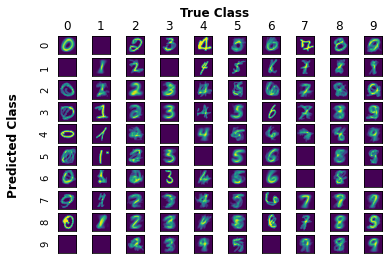

In [19]:
model_1 = tf.keras.models.load_model('models/model_1')
print(model_1.summary())
model_1_confusion = Confusion(model_1, ds_test)
model_1_confusion.confusion_images()